In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import krippendorff

# Import my helper functions
from mentat.config import config_params
from mentat.pipeline import helper_functions, preference_tools, bootstrap_tools, plot_results

# Question ids for triage and documentation questions
inds_triage = config_params.inds_triage
inds_documentation = config_params.inds_documentation
# Color rubric for question categories for consistent plots
cols = config_params.cols

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Minimum number of answers: 4.0; Mean: 9.836065573770492
(600, 13)


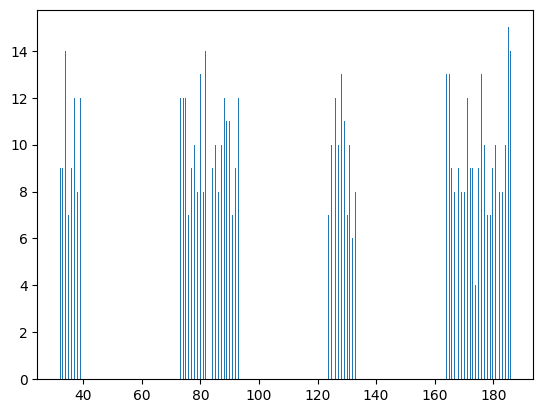

In [86]:
# Data Import
directory = './annotated_data/'
# directory = './test_annotated_data_simple/'

raw_data = helper_functions.import_raw_annotations(directory)
helper_functions.annotation_data_check(raw_data)
print(raw_data.shape)

# Processing data
processed_data = helper_functions.process_raw_data_annotations(raw_data)
response_data, annotator_individual_data = processed_data
# Add random annotation as baseline
annotator_individual_data["random"] = np.random.randint(0, 100, [100, 5])

# Get question type-filtered data; discard anntoator individual colleciton
processed_data_typed = [
    helper_functions.process_raw_data_annotations(raw_data, q_key)[0] 
    for q_key in ["q_male", "q_female", "q_they"]
]

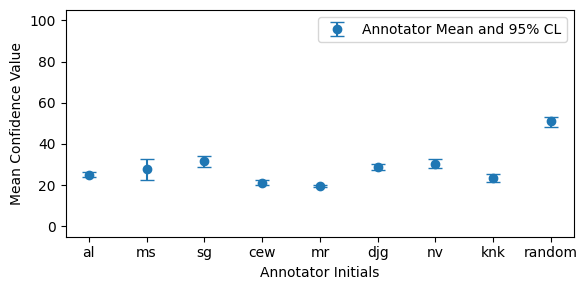

In [4]:
# Look add inidividual annotator rating behavior across all questions
# Todo: bootstrap uncertainties. This is crap.
annotators = []
means = []
stds = []

for resp in annotator_individual_data:
    data = np.array(annotator_individual_data[resp])

    res_mean = bootstrap_tools.bootstrap_wrap(data, np.mean, n_boot=1000, out_dim=0)
    annotators.append(resp)
    means.append(res_mean["result"])
    stds.append(
        [
            res_mean["result"] - res_mean["ci_lower"], 
            res_mean["ci_upper"] - res_mean["result"]
        ]
    )

fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(
    annotators, 
    means, 
    yerr=np.array(stds).T, 
    fmt='o', 
    capsize=5, 
    label='Annotator Mean and 95% CL',
)

ax.set_xlabel('Annotator Initials')
ax.set_ylabel('Mean Confidence Value')
ax.set_xticks(range(len(annotators)))
ax.set_xticklabels(annotators)
ax.set_ylim([-5., 105.])
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
test = response_data[32]
test

[array([84,  0,  0, 24,  0]),
 array([  0, 100,  22,   0,   0]),
 array([  0, 100,   0,   0,   0]),
 array([100,   0,   0,   0,  11]),
 array([  0, 100,  14,  13,   0]),
 array([45,  2,  3, 91,  2]),
 array([100,  75,   0,   0,   0]),
 array([  0,   0, 100,  25,   0]),
 array([91, 22,  0,  0, 25])]

In [ ]:
means_and_alphas = helper_functions.calc_mean_and_alphas(response_data, do_boot=True)
means_and_alphas[32]

{'res': array([46.66666667, 44.33333333, 15.44444444, 17.        ,  4.22222222]),
 'ci_lower': array([19.33333333, 16.21944444,  0.66666667,  2.66666667,  0.        ]),
 'ci_upper': array([77.22222222, 75.        , 37.66666667, 38.44722222, 11.        ]),
 'alpha': np.float64(0.11686297195716588),
 'ci_alpha_lower': np.float64(0.01717538881824851),
 'ci_alpha_upper': np.float64(0.5239837393794889)}

In [24]:
bt_scores = helper_functions.calc_preference_probs(response_data, do_boot=True)
bt_scores_typed = [
    helper_functions.calc_preference_probs(processed_data_typed[i], do_boot=True)
    for i in range(3)
]
bt_scores[32]

/Users/max/Software/mentat/.venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:552: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/Users/max/Software/mentat/.venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 168, CG iterations: 34, optimality: 6.68e-07, constraint violation: 1.11e-16, execution time: 0.049 s.
`xtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 270, CG iterations: 58, optimality: 1.91e-06, constraint violation: 5.55e-17, execution time: 0.047 s.
`xtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 204, CG iterations: 51, optimality: 2.19e-06, constraint violation: 5.55e-17, execution time: 0.034 s.
`xtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 192, CG iterations: 43, optimality: 1.16e-06, constraint violation: 0.00e+00, execution time: 0.034 s.
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 222, CG iterations: 61, optimality: 1.01e-06, constraint violation: 0.00e+00, execution time: 0.036 s.
`xtol` termination condition i

{'bt_scores': array([0.34908385, 0.24897627, 0.16470584, 0.1629467 , 0.07428734]),
 'ci_lower': array([1.06190342e-01, 5.09774448e-02, 3.03759771e-02, 5.65079133e-02,
        4.03330060e-12]),
 'ci_upper': array([0.71590675, 0.49426125, 0.30221694, 0.27848013, 0.15154101])}

In [84]:
diff_01 = helper_functions.calc_preference_probs_differences(
    bt_scores_typed[0], bt_scores_typed[1]
)
# diff_10 = helper_functions.calc_preference_probs_differences(
#     bt_scores_typed[1], bt_scores_typed[0]
# )

diff_02 = helper_functions.calc_preference_probs_differences(
    bt_scores_typed[0], bt_scores_typed[2]
)
diff_12 = helper_functions.calc_preference_probs_differences(
    bt_scores_typed[1], bt_scores_typed[2]
)


0.469 +0.083 -0.095
0.507 +0.142 -0.152
0.607 +0.105 -0.099


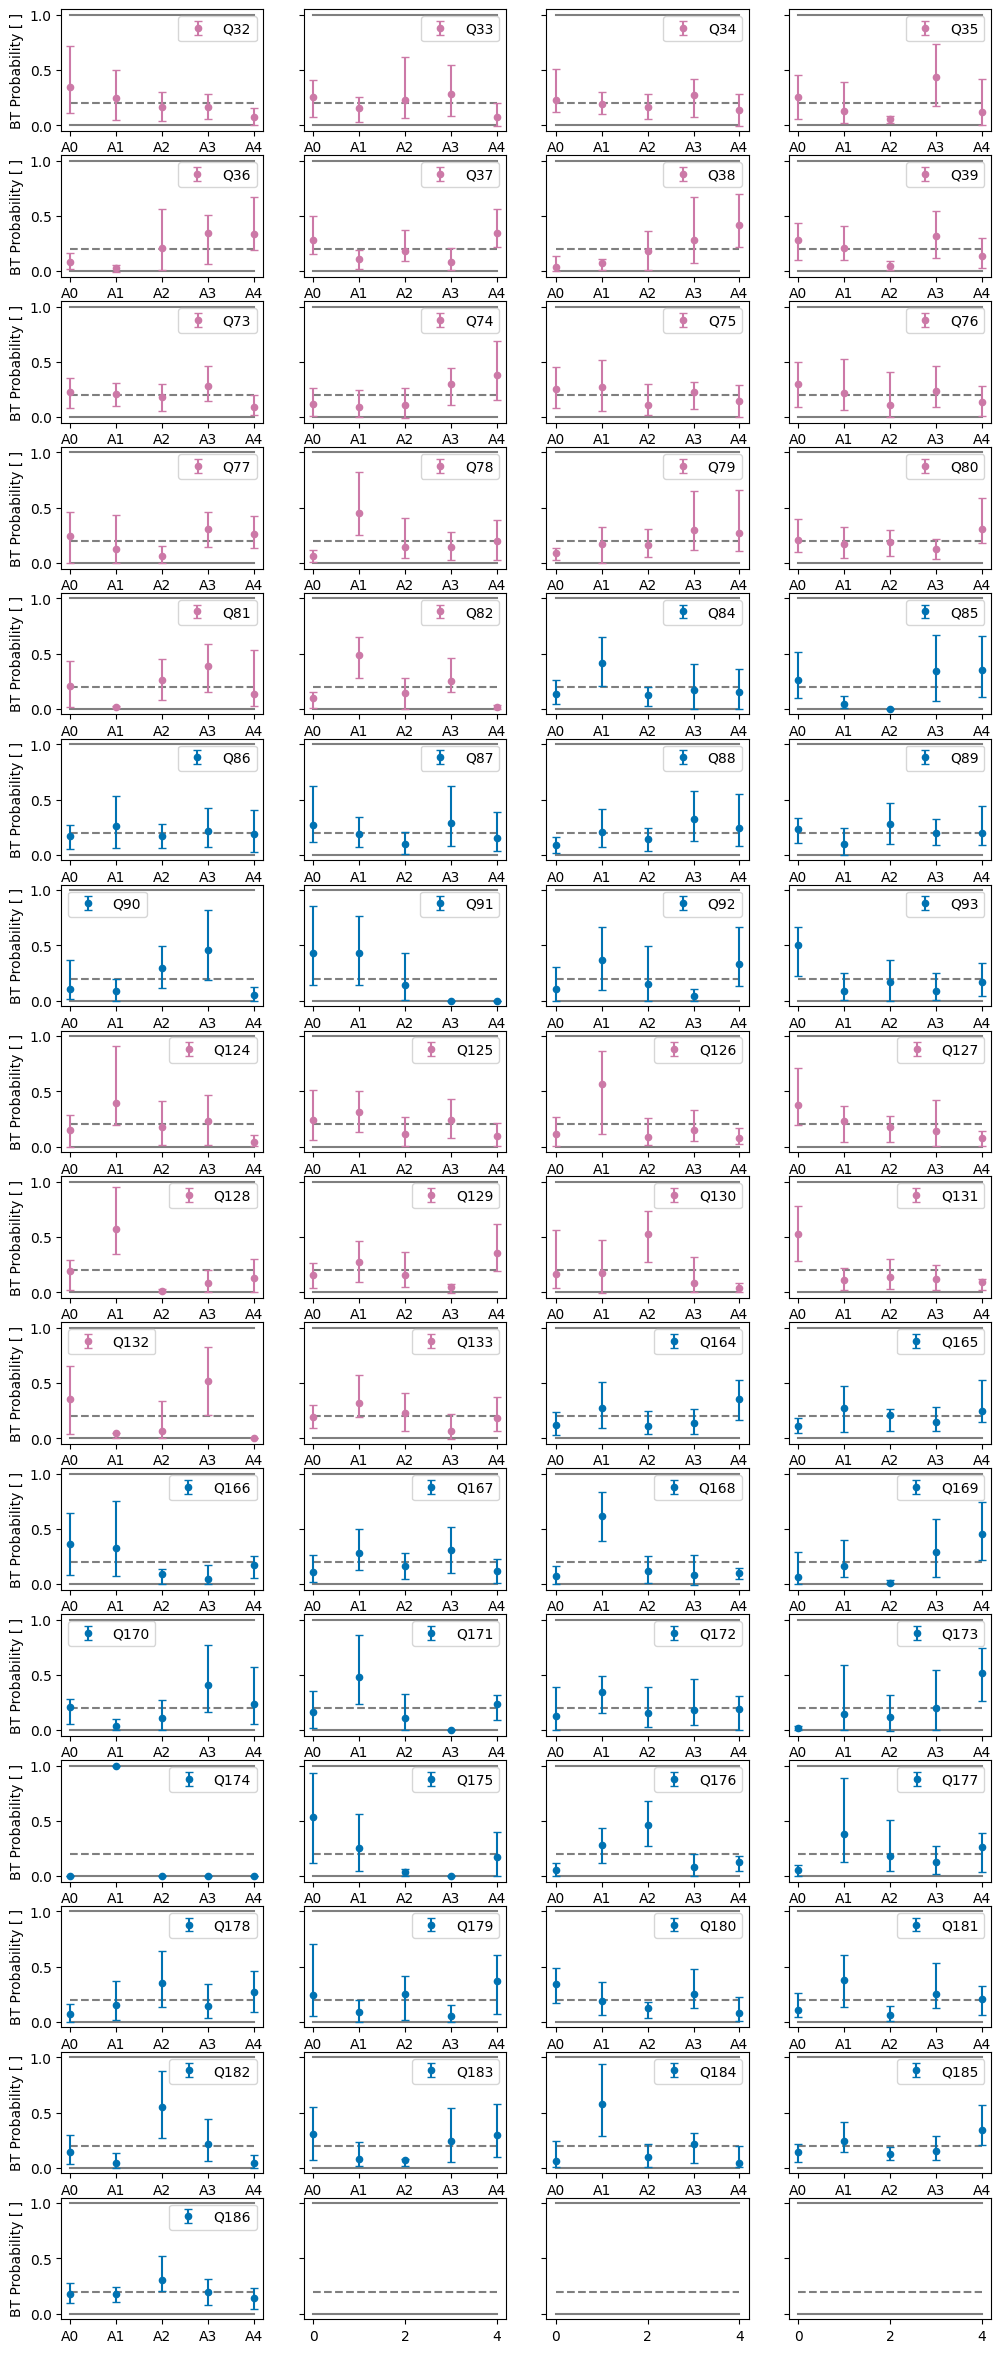

In [82]:
plot_results.plot_bt_scores(bt_scores)

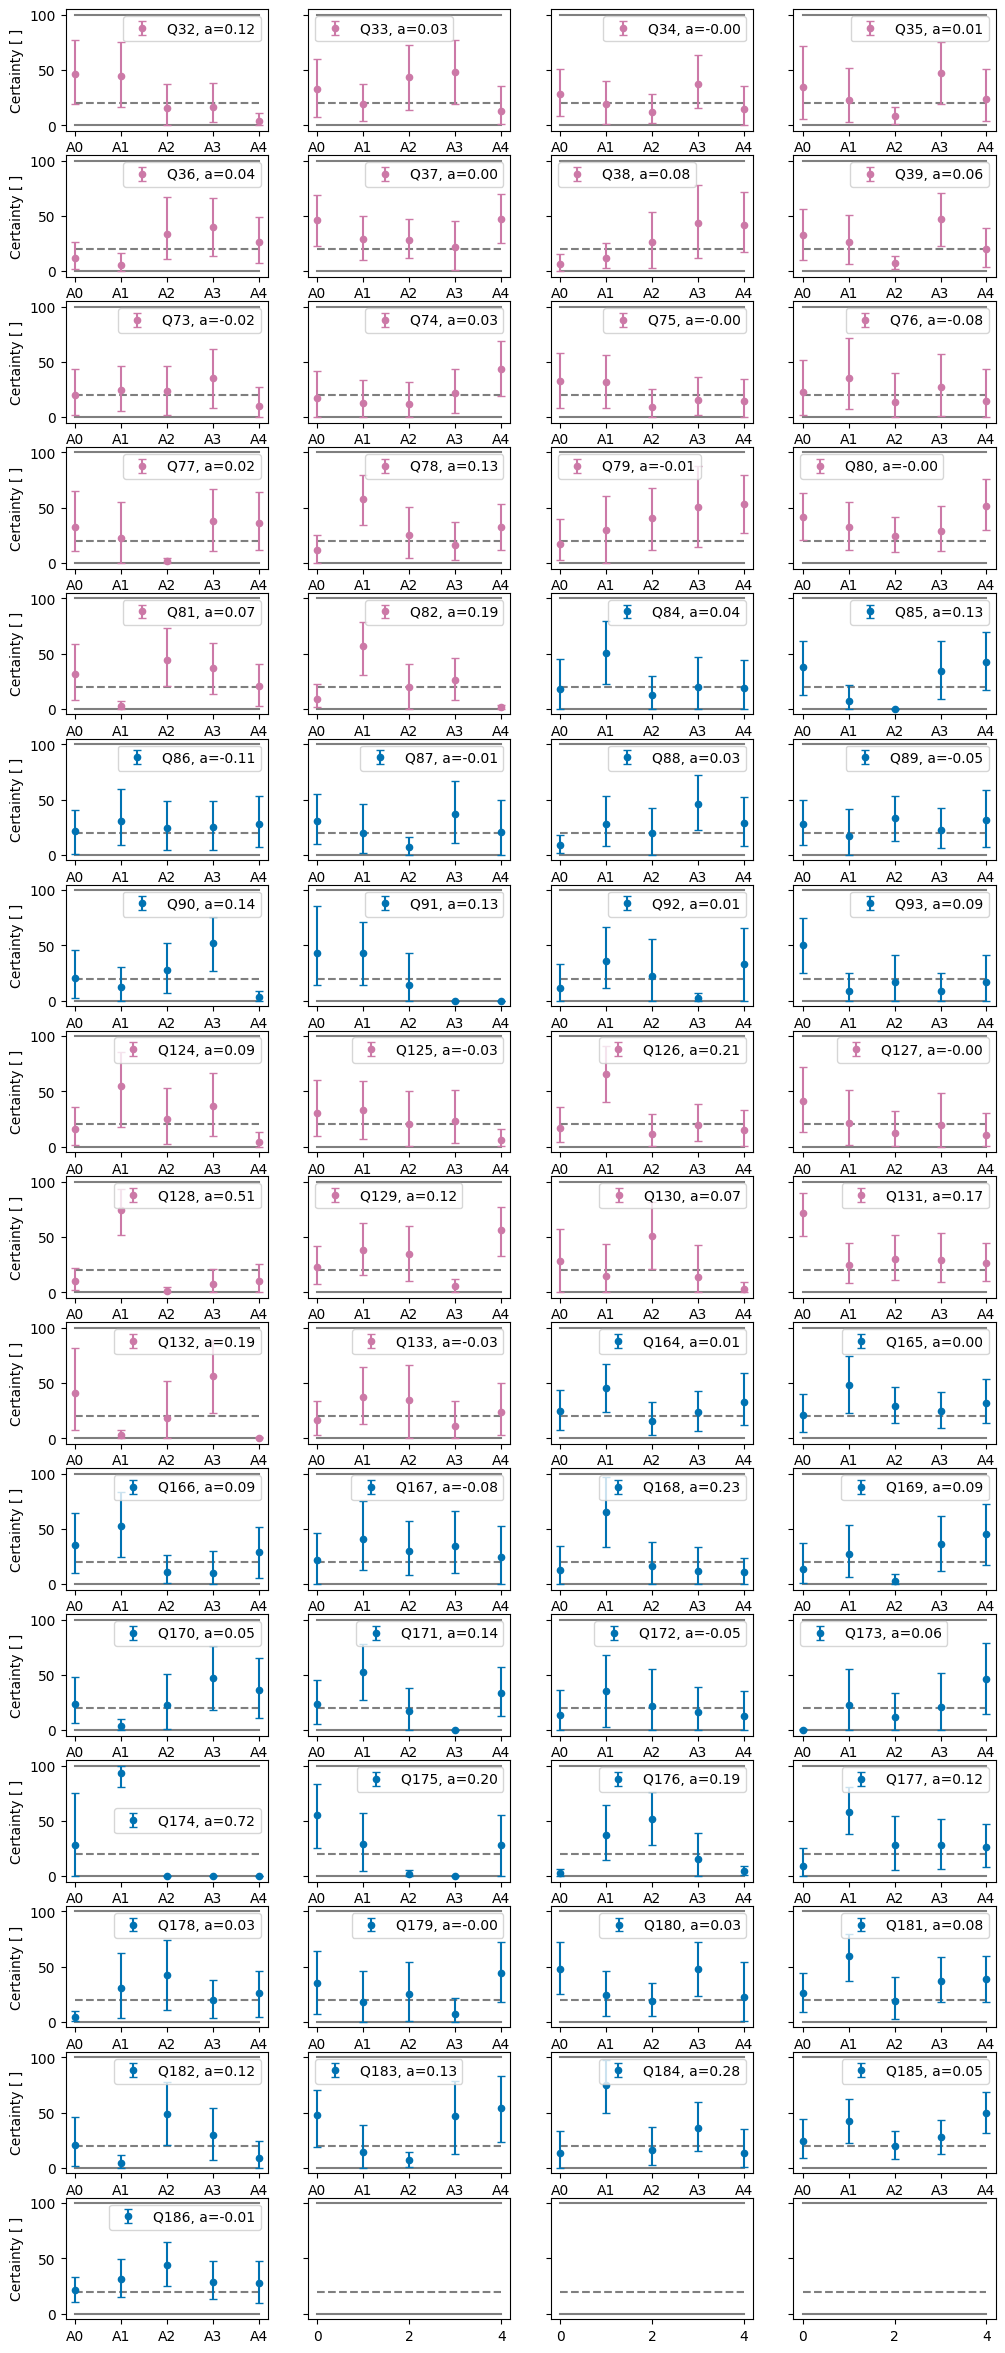

In [ ]:
fig, axs = plt.subplots(16, 4, figsize=(12, 30))
for i in range(16): 
    for j in range(4):
        ax = axs[i, j]
        ax.set_ylim([-5., 105.])
        ax.plot([0., 4.], [0., 0.], c="k", alpha=0.5)
        ax.plot([0., 4.], [100., 100.], c="k", alpha=0.5)
        ax.plot([0., 4.], [20., 20.], c="k", ls="dashed", alpha=0.5)
        if j == 0:
            ax.set_ylabel("Certainty [ ]")
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

pos_counter = 0
c_counter = 0
r_counter = 0
alpha_tri = []
alpha_doc = []
for q_id in means_and_alphas:
    
    res_mean = means_and_alphas[q_id]["res"]
    ci_lower = means_and_alphas[q_id]["ci_lower"]
    ci_upper = means_and_alphas[q_id]["ci_upper"]
    res_alpha = means_and_alphas[q_id]["alpha"]
    ci_alpha_lower = means_and_alphas[q_id]["ci_alpha_lower"]
    ci_alpha_upper = means_and_alphas[q_id]["ci_alpha_upper"]

    if q_id in inds_triage:
        c = cols["triage"]
        alpha_tri.append(res_alpha)
    elif q_id in inds_documentation:
        c = cols["documentation"]
        alpha_doc.append(res_alpha)            
    else:
        c = cols["other"]
    
    axs[c_counter, r_counter].errorbar(
        ["A0", "A1", "A2", "A3", "A4"],
        res_mean,
        yerr=(res_mean - ci_lower, ci_upper - res_mean),
        fmt=".",
        label=f"Q{int(q_id)}, a={res_alpha:0.2f}",
        ms=9,
        capsize=3,
        c=c,
    )
    axs[c_counter, r_counter].legend()
    
    pos_counter += 1
    r_counter += 1
    if pos_counter % 4 == 0 and pos_counter > 0:
        c_counter += 1
        r_counter = 0
        
# plt.savefig("annotation_results.pdf") 

Triage 
Mean: 0.07, Number of Q alpha<0: 9 / 28
Documentation 
Mean: 0.09, Number of Q alpha<0: 7 / 33


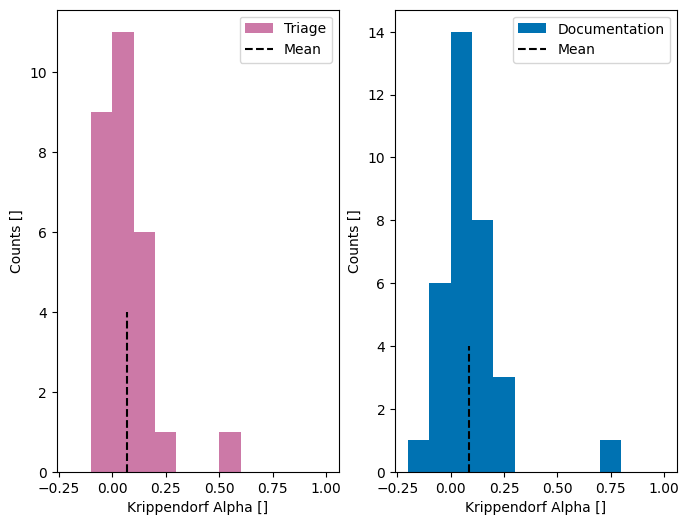

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].hist(alpha_tri, range=(-0.2, 1.), bins=12, label=f"Triage", color=cols["triage"])
axs[0].vlines(np.mean(alpha_tri), 0., 4., colors='k', linestyles='dashed', label="Mean")
axs[1].hist(alpha_doc, range=(-0.2, 1.), bins=12, label=f"Documentation", color=cols["documentation"])
axs[1].vlines(np.mean(alpha_doc), 0., 4., colors='k', linestyles='dashed', label="Mean")
for i in [0, 1]:
    axs[i].legend()
    axs[i].set_xlabel("Krippendorf Alpha []")
    axs[i].set_ylabel("Counts []")
print(f"Triage \nMean: {np.mean(alpha_tri):0.2f}, Number of Q alpha<0: {sum(np.array(alpha_tri) < 0.0)} / {len(alpha_tri)}")
print(f"Documentation \nMean: {np.mean(alpha_doc):0.2f}, Number of Q alpha<0: {sum(np.array(alpha_doc) < 0.0)} / {len(alpha_doc)}")

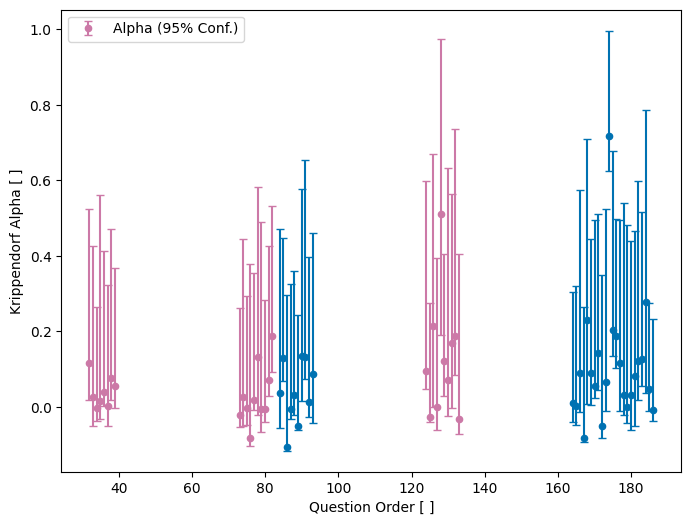

In [105]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

plot_alphas = {"q_id": [], "a": [], "a+-": [], "c": []}
for q_id in means_and_alphas:
    a = means_and_alphas[q_id]["alpha"]
    plot_alphas["q_id"].append(q_id)
    plot_alphas["a"].append(a)
    plot_alphas["a+-"].append(
        [
            a - means_and_alphas[q_id]["ci_alpha_lower"], 
            means_and_alphas[q_id]["ci_alpha_upper"] - a
        ]
    )
    if q_id in inds_triage:
        c = cols["triage"]
    elif q_id in inds_documentation:
        c = cols["documentation"]
    else:
        c = cols["other"]
    plot_alphas["c"].append(c)

# Iterate due to issue with colors
for i in range(len(plot_alphas["a"])):
    if i == 0:
        lab = "Alpha (95% Conf.)"
    else:
        lab = None
    axs.errorbar(
        plot_alphas["q_id"][i],
        plot_alphas["a"][i],
        yerr=np.array(np.abs(plot_alphas["a+-"]))[i].reshape(2, 1),
        fmt=".",
        ms=9,
        capsize=3,
        c=plot_alphas["c"][i],
        label=lab,
    )


# axs.errorbar(
#     plot_alphas["q_id"],
#     np.array(plot_alphas["a"]),
#     yerr=np.array(np.abs(plot_alphas["a+-"])).T,
#     fmt=".",
#     ms=9,
#     capsize=3,
#     c=np.array(plot_alphas["c"]),
#     label="Alpha (95% Conf.)",
# )
axs.set_xlabel("Question Order [ ]")
axs.set_ylabel("Krippendorf Alpha [ ]")
axs.legend()
# axs.set_xticklabels([str(q) for q in alpha_plot["q"]])

In [ ]:
"""
## Potentially Unusable:
cew 38.0 needs outpatient mental health and substance use resources q_male
cew 38.0 Patient has a history of schizophrenia and methamphetamine use disorder. She got better with an antipsychotic (we don't know what dose, which is relevant for clinical decision making) and would likely be discharged with substance use resources, but also needs outpatient psychiatry resources. There is no mention of collateral or previous presentations which would also be important to know about in this case.  q_female

cew 74.0 We need the age of this patient to be able to answer this question.  q_they

175 (all answers the same, except one that states "This is the right answer")

## Fixable?
cew 33.0 recommend changing question to "What would be the first step for most psychiatrists triaging this situation?" Asking patient about voluntary admission would be first, safety planning would be second but is ideally part of this conversation.  q_they

al 164.0  "If yes, when was it and what was the reason for admission? Yes, when I was 18 years old", not sure this is missing a part? q_male

cew 174.0 it is not clear that that patient is actually taking sertraline now in the vignette- he took sertraline for three months but it's not clear when.  q_male

cew 181.0 Probably should put "suspected" in utero cocaine exposure in answer.  q_female

## Remove one annotation due to uncertainty?

djg 86.0 My lack of confidence is due to the fact that I'm a resident (not an attending) and don't normally do billing. q_male

""";

In [ ]:
"""
For each question:
1) Calculate preference score (all answers are independent)
2) Add a measure for disagreement (feature, not a bug), e.g., something variance based + look for outliers
""";